# Import libraries #

In [1]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten, Input
import cv2
import matplotlib.pyplot as plt
from keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
from PIL import Image
from skimage import filters
import matplotlib.patches as patches
from keras import backend as K
from keras.models import load_model
import keras
import random

C:\Users\andyc\anaconda3\envs\env_py39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Define metrics and loss function #

In [2]:
def iou(y_true, y_pred):
    y_true = K.reshape(y_true, [-1])
    y_pred = K.reshape(y_pred, [-1])
    y_true = tf.convert_to_tensor([y_true[0],y_true[1]-y_true[3],y_true[0]+y_true[2],y_true[1]])
    y_pred = tf.convert_to_tensor([y_pred[0],y_pred[1]-y_pred[3],y_pred[0]+y_pred[2],y_pred[1]])
    xl,yl = K.maximum(y_true[0],y_pred[0]), K.maximum(y_true[1],y_pred[1])
    xr,yr = K.minimum(y_true[2],y_pred[2]), K.minimum(y_true[3],y_pred[3])
    intersection = K.maximum(float(0),(xr-xl))*K.maximum(float(0),(yr-yl))
    union = ((y_true[2]-y_true[0])*(y_true[3]-y_true[1])) + ((y_pred[2]-y_pred[0])*(y_pred[3]-y_pred[1])) - intersection
    return intersection / union

def iou_loss(y_true, y_pred):
    return (1 - iou(y_true, y_pred))

def successful_prediction(y_true, y_pred):
    iou_score = iou(y_true, y_pred)
    return K.cast(iou_score > 0.5, dtype='float32')

# Configure TensorFlow to use a GPU and manage its memory usage #

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Define data preprocess function #
Adjust the image size to the size required by EfficientNet B0 and perform grayscale conversion, noise removal, and binarization on it before adding it to List X.</br>
Change the values of the bounding box to float between 0 and 1 and add it to List Y.

In [4]:
def resize (data, IMAGE_SIZE):
    X=[]
    y=[]
    for i in range(len(data)):
        image = data[i]['image']
        resized_image = image.resize((IMAGE_SIZE,IMAGE_SIZE))
        gray = cv2.cvtColor(np.array(resized_image), cv2.COLOR_RGB2GRAY)
        denoised = cv2.bilateralFilter(gray, 11, 17, 17)
        edged = cv2.Canny(denoised, 170, 200)
        edged = np.expand_dims(edged, axis=-1)
        X.append(edged)
        label = data[i]['objects']['bbox']
        label = [label[0][0]/data[i]['width'],label[0][1]/data[i]['height'],label[0][2]/data[i]['width'],label[0][3]/data[i]['height']]
        y.append(np.array(label))
    return np.array(X),np.array(y)

# Data preprocess #
Load the data and preprocess it.

In [5]:
ds = load_dataset("keremberke/license-plate-object-detection", name="full")
traindata = ds['train']
valdata = ds['validation']
testdata = ds['test']
IMAGE_SIZE = 224
x_train , y_train = resize(traindata,IMAGE_SIZE)
print('finish train data')
x_val , y_val = resize(valdata,IMAGE_SIZE)
print('finish val data')
x_test , y_test = resize(testdata,IMAGE_SIZE)
print('finish prepose')
x_train=x_train/255
x_val=x_val/255
x_test=x_test/255

finish train data
finish val data
finish prepose


# Build, summarize, and compile deep learning models using TensorFlow's Keras API # 
This model uses the pre-trained EfficientNet B0 model for transfer learning, with the purpose of detecting bounding boxes in images.The iou is a custom metric function based on Intersection over Union, a measure of the overlap between two bounding boxes. The iou_loss is 1-iou. The sgd optimizer stands for Stochastic Gradient Descent.

In [6]:
model= Sequential()
model.add(tf.keras.applications.EfficientNetB0(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Flatten())
model.add(Dense(128, activation="relu", kernel_regularizer=regularizers.L2(0.01)))
model.add(Dense(128, activation="relu", kernel_regularizer=regularizers.L2(0.01)))
model.add(Dense(64, activation="relu", kernel_regularizer=regularizers.L2(0.01)))
model.add(Dense(4, activation="sigmoid"))
model.summary()
model.compile(loss=iou_loss, optimizer='sgd', metrics=[iou, successful_prediction])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 128)               8028288   
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                                 
Total params: 12,102,887
Trainable params: 12,060,864
No

# Train and save the model (Default learning rate) #

In [7]:
with tf.device('/GPU:0'):
    hist = model.fit(x_train, y_train,batch_size=20,epochs=50,verbose=1,validation_data=(x_val, y_val),shuffle=True)
model.save('model/my_model_iou_50.h5', overwrite=True)

Epoch 1/50
309/309 [==============================] - 104s 210ms/step - loss: 5.3968 - iou: 0.0270 - successful_prediction: 0.0000e+00 - val_loss: 5.1766 - val_iou: 1.5908e-04 - val_successful_prediction: 0.0000e+00
Epoch 2/50
309/309 [==============================] - 58s 188ms/step - loss: 4.8989 - iou: 0.0361 - successful_prediction: 0.0000e+00 - val_loss: 4.6503 - val_iou: 0.0503 - val_successful_prediction: 0.0000e+00
Epoch 3/50
309/309 [==============================] - 58s 189ms/step - loss: 4.4402 - iou: 0.0498 - successful_prediction: 0.0032 - val_loss: 4.2874 - val_iou: 0.0000e+00 - val_successful_prediction: 0.0000e+00
Epoch 4/50
309/309 [==============================] - 57s 186ms/step - loss: 4.0192 - iou: 0.0854 - successful_prediction: 0.0000e+00 - val_loss: 3.9316 - val_iou: 0.0000e+00 - val_successful_prediction: 0.0000e+00
Epoch 5/50
309/309 [==============================] - 56s 182ms/step - loss: 3.6979 - iou: 0.0767 - successful_prediction: 0.0097 - val_loss: 3.574

# Plot the training and validation loss of the model #

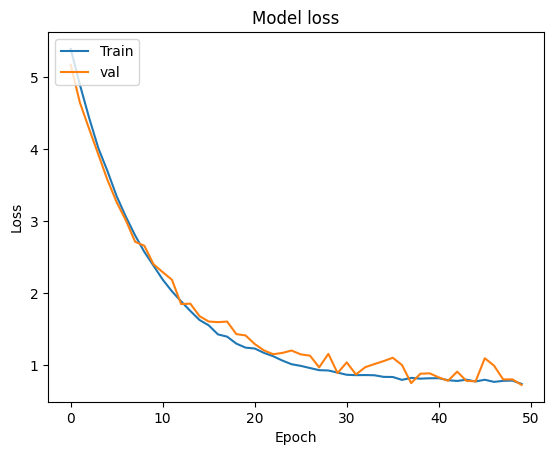

In [8]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'val'], loc='upper left')
plt.show()

# Plot the training and validation IoU of the model #

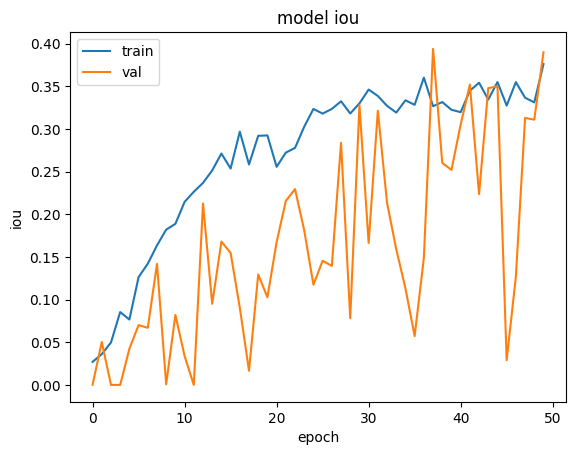

In [9]:
plt.plot(hist.history['iou'])
plt.plot(hist.history['val_iou'])
plt.title('model iou')
plt.ylabel('iou')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Print the test loss and test IoU of the model #

In [10]:
test_loss, test_iou , test_sp= model.evaluate(x_test, y_test, verbose=2)
print('\nTest iou:', test_iou)
print('\nTest loss:', test_loss)

28/28 - 3s - loss: 0.6968 - iou: 0.4249 - successful_prediction: 0.5000 - 3s/epoch - 100ms/step

Test iou: 0.4249099791049957

Test loss: 0.6968074440956116


# Prediction #

1/1 [==============================] - 3s 3s/step
[0.48290196 0.6626846  0.20358925 0.12045562]
[264.0, 227.0, 83.0, 20.0]
227 200 96 36


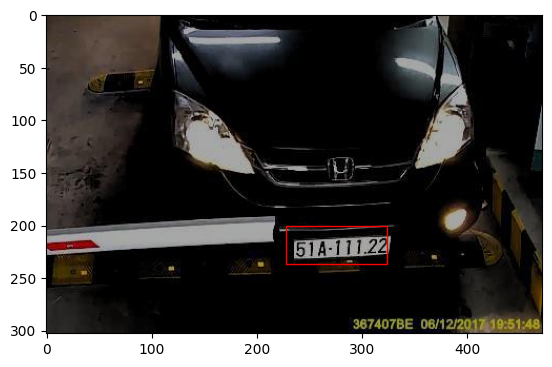

In [11]:
ran_num = random.randint(0,len(x_test))
y = model.predict(x_test[ran_num:ran_num+1])[0]
print(y)
print(testdata[0]['objects']['bbox'][0])
print(int(y[0]*testdata[ran_num]['width']), int(y[1]*testdata[ran_num]['height']), int((y[2])*testdata[ran_num]['width']), int((y[3])*testdata[ran_num]['height']))
fig, ax = plt.subplots(1)
ax.imshow(testdata[ran_num]['image'])
rect = patches.Rectangle((y[0]*testdata[ran_num]['width'], y[1]*testdata[ran_num]['height']), int((y[2])*testdata[ran_num]['width']), int((y[3])*testdata[ran_num]['height']), linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.show()

# Train and save the model (Default learning rate) #

In [28]:
model = load_model('model/my_model_iou_50.h5', custom_objects={'iou': iou, 'iou_loss': iou_loss, 'successful_prediction': successful_prediction})
with tf.device('/GPU:0'):
    hist = model.fit(x_train, y_train,batch_size=20,epochs=50,verbose=1,validation_data=(x_val, y_val),shuffle=True)
model.save('model/my_model_iou_100.h5', overwrite=True)

Epoch 1/50
309/309 [==============================] - 74s 207ms/step - loss: 0.7784 - iou: 0.3388 - successful_prediction: 0.2848 - val_loss: 0.8362 - val_iou: 0.2785 - val_successful_prediction: 0.1685
Epoch 2/50
309/309 [==============================] - 57s 186ms/step - loss: 0.7780 - iou: 0.3384 - successful_prediction: 0.2589 - val_loss: 0.7482 - val_iou: 0.3678 - val_successful_prediction: 0.2921
Epoch 3/50
309/309 [==============================] - 57s 186ms/step - loss: 0.7663 - iou: 0.3510 - successful_prediction: 0.3139 - val_loss: 0.7244 - val_iou: 0.3912 - val_successful_prediction: 0.3483
Epoch 4/50
309/309 [==============================] - 57s 185ms/step - loss: 0.7647 - iou: 0.3526 - successful_prediction: 0.2589 - val_loss: 0.8065 - val_iou: 0.3101 - val_successful_prediction: 0.2360
Epoch 5/50
309/309 [==============================] - 58s 187ms/step - loss: 0.7571 - iou: 0.3592 - successful_prediction: 0.2913 - val_loss: 0.7373 - val_iou: 0.3773 - val_successful_pred

# Plot the training and validation loss of the model #

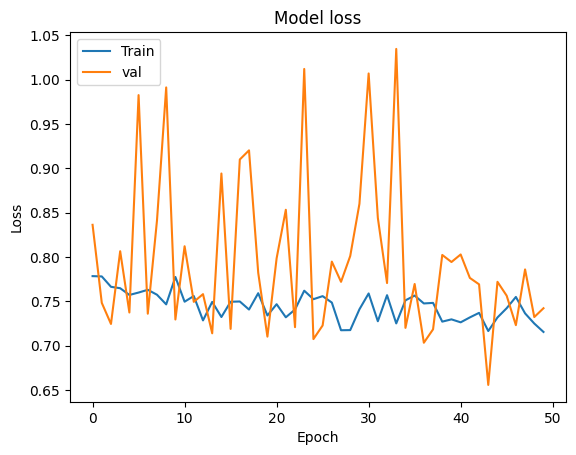

In [31]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'val'], loc='upper left')
plt.show()

# Plot the training and validation IoU of the model #

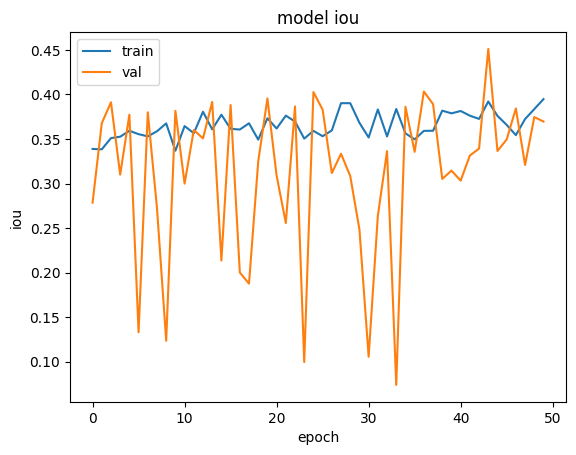

In [32]:
plt.plot(hist.history['iou'])
plt.plot(hist.history['val_iou'])
plt.title('model iou')
plt.ylabel('iou')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Prediction #

1/1 [==============================] - 0s 62ms/step
tf.Tensor(0.5479214142588151, shape=(), dtype=float64)
[0.48500568 0.6881287  0.19171572 0.12007381]
[264.0, 227.0, 83.0, 20.0]
228 208 90 36


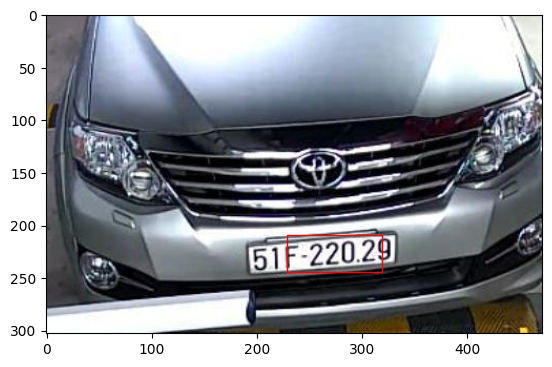

In [33]:
ran_num = random.randint(0,len(x_test))
y = model.predict(x_test[ran_num:ran_num+1])[0]
y_test_double = tf.cast(y_test, tf.double)
y_double = tf.cast(y, tf.double)
print(iou(y_test_double[ran_num], y_double))
print(y)
print(testdata[0]['objects']['bbox'][0])
print(int(y[0]*testdata[ran_num]['width']), int(y[1]*testdata[ran_num]['height']), int((y[2])*testdata[ran_num]['width']), int((y[3])*testdata[ran_num]['height']))
fig, ax = plt.subplots(1)
ax.imshow(testdata[ran_num]['image'])
rect = patches.Rectangle((y[0]*testdata[ran_num]['width'], y[1]*testdata[ran_num]['height']), int((y[2])*testdata[ran_num]['width']), int((y[3])*testdata[ran_num]['height']), linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.show()

# Train and save the model (Learning rate = 0.001) #

In [38]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
model = load_model('model/my_model_iou_100.h5', custom_objects={'iou': iou, 'iou_loss': iou_loss, 'successful_prediction': successful_prediction})
model.compile(loss=iou_loss, optimizer=keras.optimizers.SGD(learning_rate=0.001), metrics=[iou, successful_prediction])
with tf.device('/GPU:0'):
    hist = model.fit(x_train, y_train,batch_size=20,epochs=50,verbose=1,validation_data=(x_val, y_val),shuffle=True)
model.save('model/my_model_iou_150.h5', overwrite=True)

Epoch 1/50
309/309 [==============================] - 103s 203ms/step - loss: 0.6865 - iou: 0.4246 - successful_prediction: 0.4337 - val_loss: 0.6641 - val_iou: 0.4452 - val_successful_prediction: 0.4831
Epoch 2/50
309/309 [==============================] - 58s 187ms/step - loss: 0.6196 - iou: 0.4899 - successful_prediction: 0.5210 - val_loss: 0.6278 - val_iou: 0.4790 - val_successful_prediction: 0.5393
Epoch 3/50
309/309 [==============================] - 57s 184ms/step - loss: 0.6241 - iou: 0.4842 - successful_prediction: 0.5405 - val_loss: 0.6159 - val_iou: 0.4905 - val_successful_prediction: 0.5618
Epoch 4/50
309/309 [==============================] - 57s 186ms/step - loss: 0.6124 - iou: 0.4952 - successful_prediction: 0.5566 - val_loss: 0.6105 - val_iou: 0.4958 - val_successful_prediction: 0.5730
Epoch 5/50
309/309 [==============================] - 57s 185ms/step - loss: 0.5924 - iou: 0.5141 - successful_prediction: 0.6084 - val_loss: 0.5999 - val_iou: 0.5050 - val_successful_pre

# Plot the training and validation loss of the model #

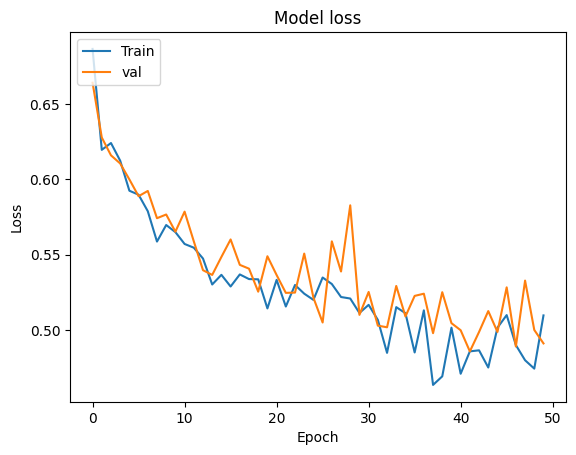

In [39]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'val'], loc='upper left')
plt.show()

# Plot the training and validation IoU of the model #

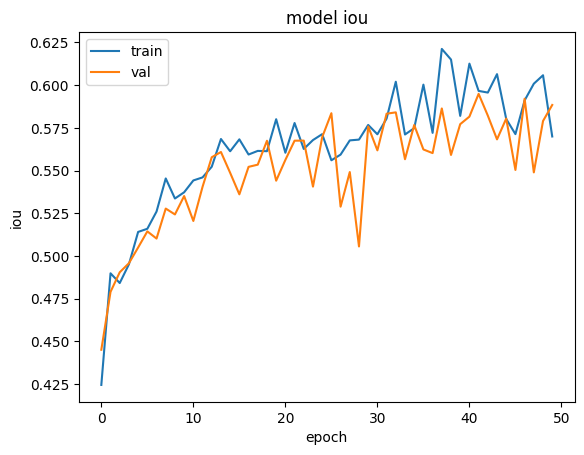

In [40]:
plt.plot(hist.history['iou'])
plt.plot(hist.history['val_iou'])
plt.title('model iou')
plt.ylabel('iou')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Prediction #

1/1 [==============================] - 0s 63ms/step
tf.Tensor(0.8218379652958715, shape=(), dtype=float64)
[0.23101942 0.3443673  0.43981394 0.37738803]
[264.0, 227.0, 83.0, 20.0]
138 165 263 181


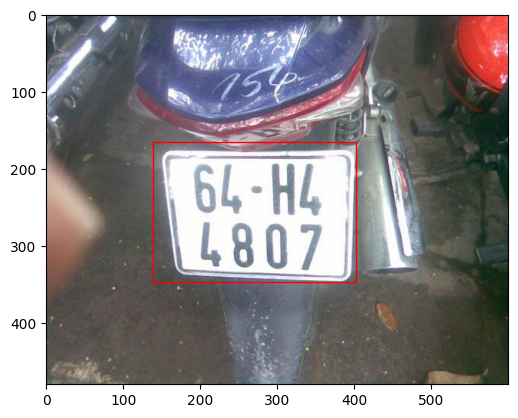

In [46]:
model_150=load_model('model/my_model_iou_150.h5', custom_objects={'iou': iou, 'iou_loss': iou_loss, 'successful_prediction': successful_prediction})
ran_num = random.randint(0,len(x_test))
y = model.predict(x_test[ran_num:ran_num+1])[0]
y_test_double = tf.cast(y_test, tf.double)
y_double = tf.cast(y, tf.double)
print(iou(y_test_double[ran_num], y_double))
print(y)
print(testdata[0]['objects']['bbox'][0])
print(int(y[0]*testdata[ran_num]['width']), int(y[1]*testdata[ran_num]['height']), int((y[2])*testdata[ran_num]['width']), int((y[3])*testdata[ran_num]['height']))
fig, ax = plt.subplots(1)
ax.imshow(testdata[ran_num]['image'])
rect = patches.Rectangle((y[0]*testdata[ran_num]['width'], y[1]*testdata[ran_num]['height']), int((y[2])*testdata[ran_num]['width']), int((y[3])*testdata[ran_num]['height']), linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.show()

# Train and save the model (Learning rate = 0.0001) #

In [6]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
model = load_model('model/my_model_iou_150.h5', custom_objects={'iou': iou, 'iou_loss': iou_loss, 'successful_prediction': successful_prediction})
model.compile(loss=iou_loss, optimizer=keras.optimizers.SGD(learning_rate=0.0001), metrics=[iou, successful_prediction])
with tf.device('/GPU:0'):
    hist = model.fit(x_train, y_train,batch_size=20,epochs=50,verbose=1,validation_data=(x_val, y_val),shuffle=True)
model.save('model/my_model_iou_200.h5', overwrite=True)

Epoch 1/50
309/309 [==============================] - 98s 208ms/step - loss: 0.4322 - iou: 0.6477 - successful_prediction: 0.8026 - val_loss: 0.4673 - val_iou: 0.6120 - val_successful_prediction: 0.7640
Epoch 2/50
309/309 [==============================] - 59s 190ms/step - loss: 0.4555 - iou: 0.6243 - successful_prediction: 0.7508 - val_loss: 0.4673 - val_iou: 0.6120 - val_successful_prediction: 0.7640
Epoch 3/50
309/309 [==============================] - 59s 190ms/step - loss: 0.4614 - iou: 0.6184 - successful_prediction: 0.7702 - val_loss: 0.4685 - val_iou: 0.6109 - val_successful_prediction: 0.7640
Epoch 4/50
309/309 [==============================] - 59s 190ms/step - loss: 0.4332 - iou: 0.6463 - successful_prediction: 0.7896 - val_loss: 0.4623 - val_iou: 0.6172 - val_successful_prediction: 0.7865
Epoch 5/50
309/309 [==============================] - 58s 189ms/step - loss: 0.4692 - iou: 0.6104 - successful_prediction: 0.7476 - val_loss: 0.4613 - val_iou: 0.6178 - val_successful_pred

# Plot the training and validation loss of the model #

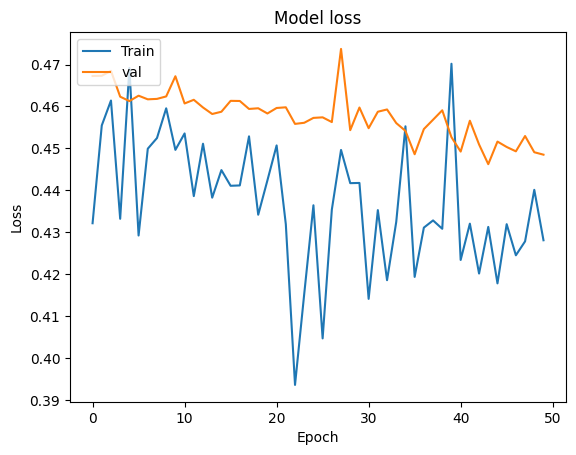

In [7]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'val'], loc='upper left')
plt.show()

# Plot the training and validation IoU of the model #

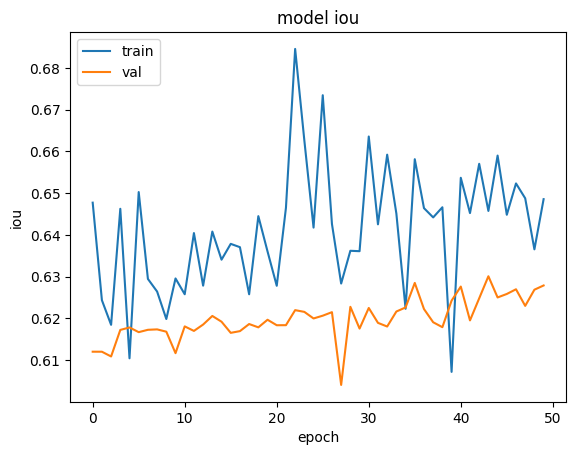

In [8]:
plt.plot(hist.history['iou'])
plt.plot(hist.history['val_iou'])
plt.title('model iou')
plt.ylabel('iou')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Prediction #

1/1 [==============================] - 0s 57ms/step
tf.Tensor(0.4952485431480588, shape=(), dtype=float64)
[0.20922452 0.5487465  0.2573773  0.16859943]
[264.0, 227.0, 83.0, 20.0]
98 166 121 51


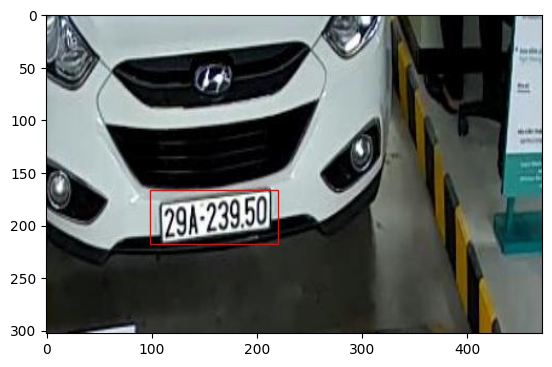

In [34]:
ran_num = random.randint(0,len(x_test))
y = model.predict(x_test[ran_num:ran_num+1])[0]
y_test_double = tf.cast(y_test, tf.double)
y_double = tf.cast(y, tf.double)
print(iou(y_test_double[ran_num], y_double))
print(y)
print(testdata[0]['objects']['bbox'][0])
print(int(y[0]*testdata[ran_num]['width']), int(y[1]*testdata[ran_num]['height']), int((y[2])*testdata[ran_num]['width']), int((y[3])*testdata[ran_num]['height']))
fig, ax = plt.subplots(1)
ax.imshow(testdata[ran_num]['image'])
rect = patches.Rectangle((y[0]*testdata[ran_num]['width'], y[1]*testdata[ran_num]['height']), int((y[2])*testdata[ran_num]['width']), int((y[3])*testdata[ran_num]['height']), linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.show()

# Train and save the model (Learning rate = 0.00001) #

In [6]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
model = load_model('model/my_model_iou_200.h5', custom_objects={'iou': iou, 'iou_loss': iou_loss, 'successful_prediction': successful_prediction})
model.compile(loss=iou_loss, optimizer=keras.optimizers.SGD(learning_rate=0.00001), metrics=[iou, successful_prediction])
with tf.device('/GPU:0'):
    hist = model.fit(x_train, y_train,batch_size=20,epochs=50,verbose=1,validation_data=(x_val, y_val),shuffle=True)
model.save('model/my_model_iou_250.h5', overwrite=True)

Epoch 1/50
309/309 [==============================] - 95s 209ms/step - loss: 0.4295 - iou: 0.6468 - successful_prediction: 0.7832 - val_loss: 0.4476 - val_iou: 0.6288 - val_successful_prediction: 0.8202
Epoch 2/50
309/309 [==============================] - 58s 188ms/step - loss: 0.4188 - iou: 0.6578 - successful_prediction: 0.8123 - val_loss: 0.4476 - val_iou: 0.6286 - val_successful_prediction: 0.8202
Epoch 3/50
309/309 [==============================] - 58s 188ms/step - loss: 0.4195 - iou: 0.6570 - successful_prediction: 0.8058 - val_loss: 0.4479 - val_iou: 0.6282 - val_successful_prediction: 0.8202
Epoch 4/50
309/309 [==============================] - 58s 188ms/step - loss: 0.4480 - iou: 0.6285 - successful_prediction: 0.7638 - val_loss: 0.4488 - val_iou: 0.6273 - val_successful_prediction: 0.8202
Epoch 5/50
309/309 [==============================] - 59s 190ms/step - loss: 0.3995 - iou: 0.6770 - successful_prediction: 0.8382 - val_loss: 0.4459 - val_iou: 0.6299 - val_successful_pred

# Plot the training and validation loss of the model #

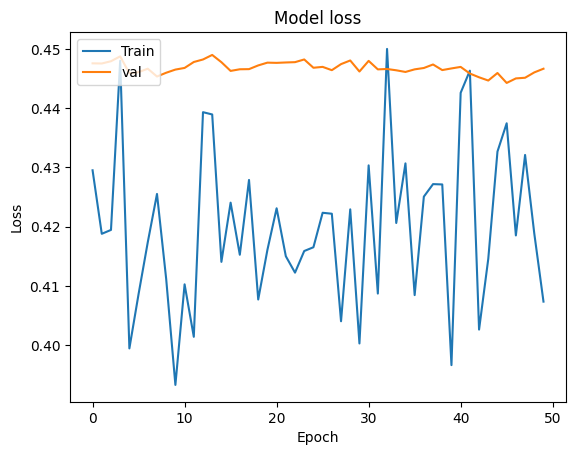

In [7]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'val'], loc='upper left')
plt.show()

# Plot the training and validation IoU of the model #

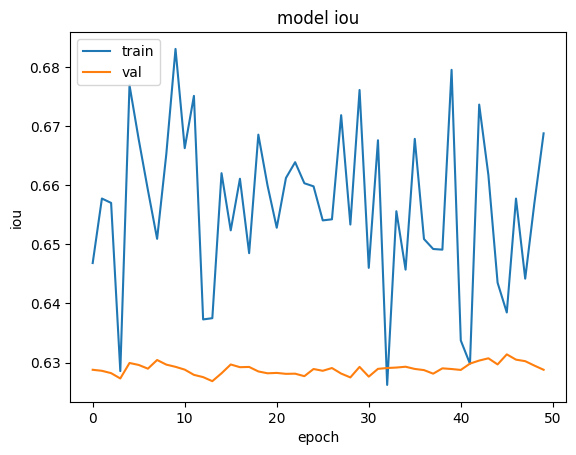

In [8]:
plt.plot(hist.history['iou'])
plt.plot(hist.history['val_iou'])
plt.title('model iou')
plt.ylabel('iou')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Prediction #

1/1 [==============================] - 0s 68ms/step
tf.Tensor(0.8735710999437956, shape=(), dtype=float64)
[0.45232502 0.5935202  0.2106879  0.12100044]
[264.0, 227.0, 83.0, 20.0]
213 179 99 36


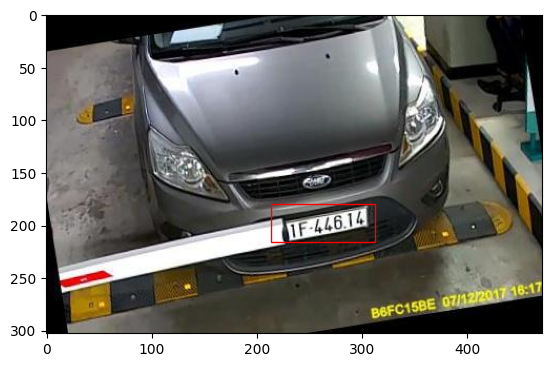

In [17]:
ran_num = random.randint(0,len(x_test))
model = load_model('model/my_model_iou_250.h5', custom_objects={'iou': iou, 'iou_loss': iou_loss, 'successful_prediction': successful_prediction})
y = model.predict(x_test[ran_num:ran_num+1])[0]
y_test_double = tf.cast(y_test, tf.double)
y_double = tf.cast(y, tf.double)
print(iou(y_test_double[ran_num], y_double))
print(y)
print(testdata[0]['objects']['bbox'][0])
print(int(y[0]*testdata[ran_num]['width']), int(y[1]*testdata[ran_num]['height']), int((y[2])*testdata[ran_num]['width']), int((y[3])*testdata[ran_num]['height']))
fig, ax = plt.subplots(1)
ax.imshow(testdata[ran_num]['image'])
rect = patches.Rectangle((y[0]*testdata[ran_num]['width'], y[1]*testdata[ran_num]['height']), int((y[2])*testdata[ran_num]['width']), int((y[3])*testdata[ran_num]['height']), linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.show()

In [6]:
model = load_model('model/my_model_iou_250.h5', custom_objects={'iou': iou, 'iou_loss': iou_loss, 'successful_prediction': successful_prediction})

In [7]:
test_loss, test_iou , test_sp= model.evaluate(x_test, y_test, verbose=2)
print('\nTest iou:', test_iou)
print('\nTest loss:', test_loss)

28/28 - 8s - loss: 0.3972 - iou: 0.6796 - successful_prediction: 0.7857 - 8s/epoch - 284ms/step

Test iou: 0.6795848608016968

Test loss: 0.39724814891815186
